In [53]:
# 定义所需的包
required_packages <- c("zipfR", "ggplot2", "stringr", "scales", "tibble", "dplyr", "gss")

# 检查并安装缺少的包
for (pkg in required_packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  }
}

In [34]:
# 设置文件夹路径
folder_path <- "output_txt_files"

# 获取所有txt文件
files <- list.files(folder_path, pattern = "\\.txt$", full.names = TRUE)


In [35]:
# 准备数据框存储结果
results <- data.frame(File = character(), Type = character(), Model = character(), Rank = numeric(), Frequency = numeric())

for (file in files) {
  # 读取文件内容
  text <- tolower(readLines(file, warn = FALSE))
  text <- unlist(strsplit(text, "\\W+"))
  text <- text[text != ""]

  # 计算词频
  freq <- table(text)
  freq <- sort(freq, decreasing = TRUE)

  # 提取文件名中的信息
  file_info <- str_match(basename(file), "(.*) (.*)\\d_responses.txt")
  if (length(file_info) < 3) next  # 确保文件名符合预期格式

  model <- file_info[2]
  type <- file_info[3]

  # 数据框存储结果
  temp_df <- data.frame(File = basename(file), Type = type, Model = model, Rank = 1:length(freq), Frequency = as.numeric(freq))
  results <- rbind(results, temp_df)
}
  print(results)

                                 File     Type    Model Rank Frequency
1    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    1       157
2    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    2        94
3    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    3        77
4    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    4        65
5    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    5        58
6    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    6        47
7    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    7        41
8    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    8        37
9    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    9        35
10   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   10        31
11   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   11        29
12   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   12        27
13   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   13        26
14   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   14        23
15   Deepseek 创意写作1_responses.txt 创意写作 Deepseek

In [36]:
# 加载所需的库
library(zipfR)

# 初始化拟合结果列表
fit_results <- list()

# 遍历每个唯一的文件进行 Zipf-Mandelbrot 拟合
for (file in unique(results$File)) {
  # 提取该文件的相关数据
  data <- subset(results, File == file)

  # 打印提取的数据
  print(data)

  # 确保数据的列名正确
  print(colnames(data))

  # 调用 spc 函数前检查数据框的内容
  print(head(data))

  # 准备 spc 函数的参数
  N <- sum(data$Frequency)  # 样本大小
  V <- length(data$Frequency)  # 频率向量的长度
  Vm <- table(data$Frequency)  # 频率为 m 的类型数
  m <- as.numeric(names(Vm))  # 频率

  # 调用 spc 函数
  fit <- tryCatch({
    spc(N = N, V = V, Vm = as.numeric(Vm), m = m)
  }, error = function(e) {
    print(paste("Error in spc function:", e))
    NULL
  })

  # 打印 spc 函数的结果
  print(fit)

  # 存储拟合结果
  fit_results[[file]] <- fit
}

# 打印最终的拟合结果
print(fit_results)


                                File     Type    Model Rank Frequency
1   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    1       157
2   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    2        94
3   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    3        77
4   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    4        65
5   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    5        58
6   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    6        47
7   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    7        41
8   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    8        37
9   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    9        35
10  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   10        31
11  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   11        29
12  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   12        27
13  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   13        26
14  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   14        23
15  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   15        22


`geom_smooth()` using formula = 'y ~ x'


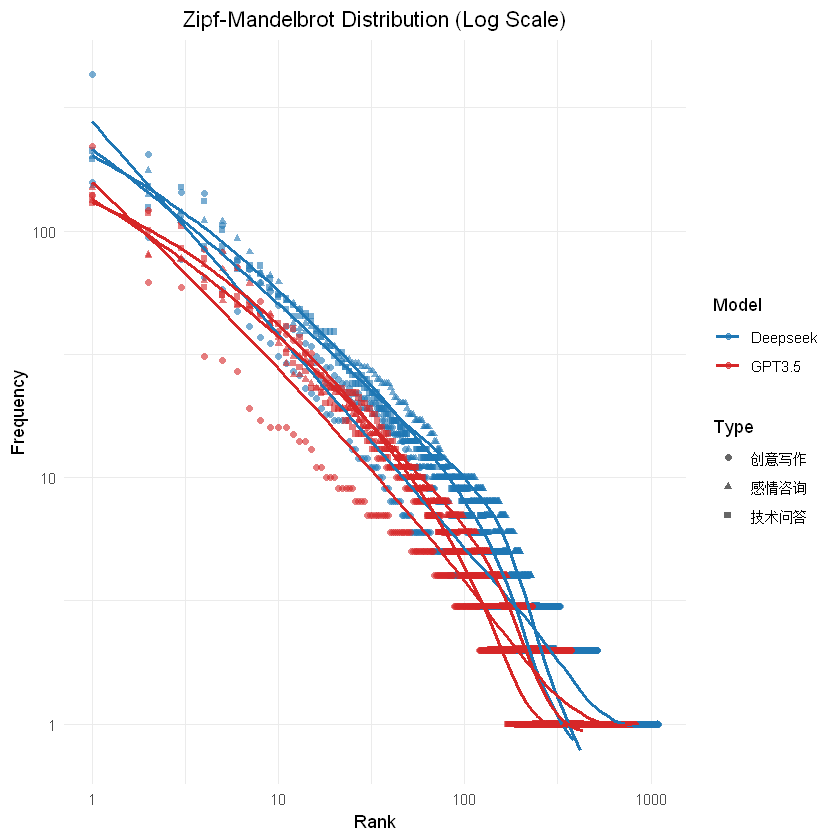

In [47]:
model_colors <- c("Deepseek" = "#1f77b4", "Model2" = "#2ca02c", "GPT3.5" = "#d62728") # 示例颜色

# 绘图
ggplot(results, aes(x = Rank, y = Frequency, color = Model, shape = Type)) +
  geom_point(alpha = 0.6) + # 使用alpha参数使点更透明
  geom_smooth(se = FALSE, method = "loess") + # 添加平滑曲线
  scale_color_manual(values = model_colors) + # 手动设定颜色
  labs(title = "Zipf-Mandelbrot Distribution (Log Scale)", x = "Rank", y = "Frequency") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5), # 标题居中
    legend.position = "right" # 图例位置
  ) +
  scale_x_log10() + # 对 x 轴进行对数变换
  scale_y_log10() # 对 y 轴进行对数变换


`geom_smooth()` using formula = 'y ~ x'


Warning message:
"Removed 111 rows containing missing values or values outside the scale range
(`geom_smooth()`)."


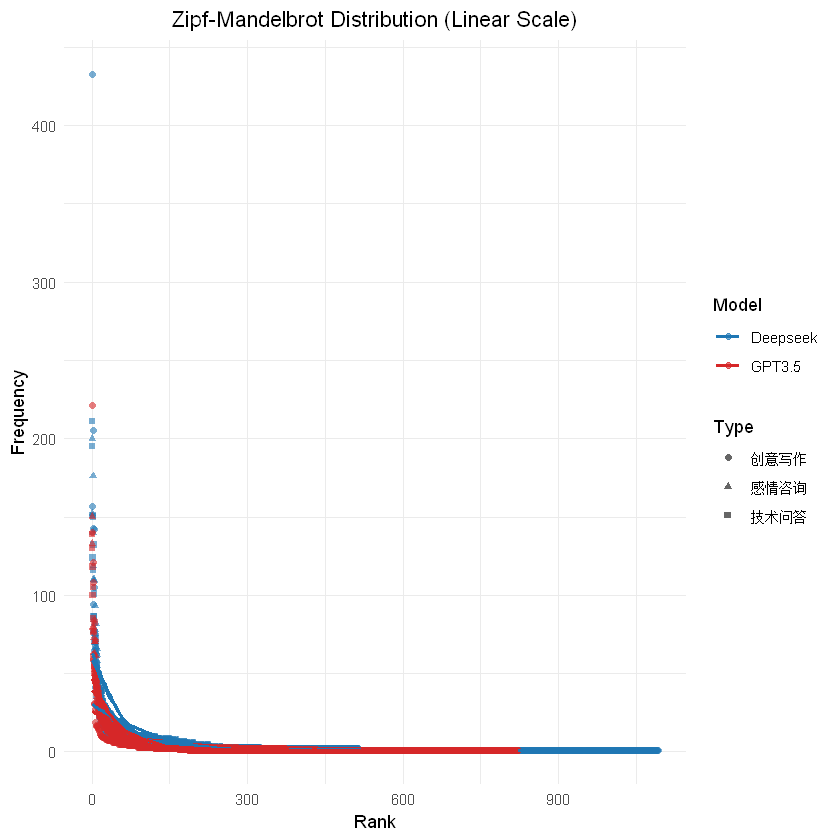

In [48]:
model_colors <- c("Deepseek" = "#1f77b4", "Model2" = "#2ca02c", "GPT3.5" = "#d62728") # 示例颜色

# 绘图
ggplot(results, aes(x = Rank, y = Frequency, color = Model, shape = Type)) +
  geom_point(alpha = 0.6) + # 使用alpha参数使点更透明
  geom_smooth(se = FALSE, method = "loess") + # 添加平滑曲线
  scale_color_manual(values = model_colors) + # 手动设定颜色
  labs(title = "Zipf-Mandelbrot Distribution (Linear Scale)", x = "Rank", y = "Frequency") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5), # 标题居中
    legend.position = "right" # 图例位置
  ) +
  scale_x_continuous(limits = c(min(results$Rank), max(results$Rank))) + # 调整x轴范围
  scale_y_continuous(limits = c(min(results$Frequency), max(results$Frequency))) # 调整y轴范围


In [57]:
# 确保 Rank 和 Frequency 列是数值型的
results$Rank <- as.numeric(as.character(results$Rank))
results$Frequency <- as.numeric(as.character(results$Frequency))

# 确保 Model 和 Type 列是因子型的
results$Model <- as.factor(results$Model)
results$Type <- as.factor(results$Type)
# ssanova 分析
library(gss)

# 使用 gss 进行分析
ssanova_results <- ssanova(Frequency ~ Rank * Model * Type, data = results)

# 打印 ssanova 结果
print(ssanova_results)



Call:
ssanova(formula = Frequency ~ Rank * Model * Type, data = results)

Terms:
[1] "1"               "Rank"            "Model"           "Type"           
[5] "Rank:Model"      "Rank:Type"       "Model:Type"      "Rank:Model:Type"

Number of unpenalized and penalized terms:

                Unpenalized Penalized
1                         1         0
Rank                      1         1
Model                     1         0
Type                      0         1
Rank:Model                1         1
Rank:Type                 0         2
Model:Type                0         1
Rank:Model:Type           0         2
total                     4         8

Smoothing parameters are selected by GCV with alpha=1.4.
